# Banl Marketing <img src="./images/dataset-cover.PNG" width="400"  align="right"/> 
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

The following information is drawn from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/bank+marketing

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Preparing Data for Analysis](#2)
  - [ 2.1 Dataload Dataset](#2.1)
  - [ 2.2 Feuture engineering](#2.2)
  - [ 2.3 Scaling & Encoding](#2.3)
- [ 3 - Principal Component Analysis](#3)
- [ 4 - Modeling](#4)  
- [ 5 - Evaluation](#5)  
- [ 6 - Neural Networks](#6)
- [ 7 - Evaluation](#7) 
- [ 8 - K-Means-Algorithmus](#8) 

<a name="1"></a>
## Packages

* Machine Learning - Unsupervised Learning (PCA, k-means-clustering)
* Machine Learning - Supervised Learning (Logistic regression, XGBooster)
* Tensorflow and Keras - Convolutional neural network

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.colors as mc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import  cross_val_predict
from sklearn.metrics import roc_curve

<a name="2"></a>
## Preparing Data for Analysis
### Dataload Dataset

In [83]:
data  = pd.read_csv("data/bank-additional-full.csv", sep = ";",keep_default_na = False)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [84]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [85]:
data.describe(include = 'all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


In [86]:
# Check for missings
print(len(data.columns[data.isna().any()])/len(data.columns))
print(data.isnull().sum().sum()/np.product(data.shape))

0.0
0.0


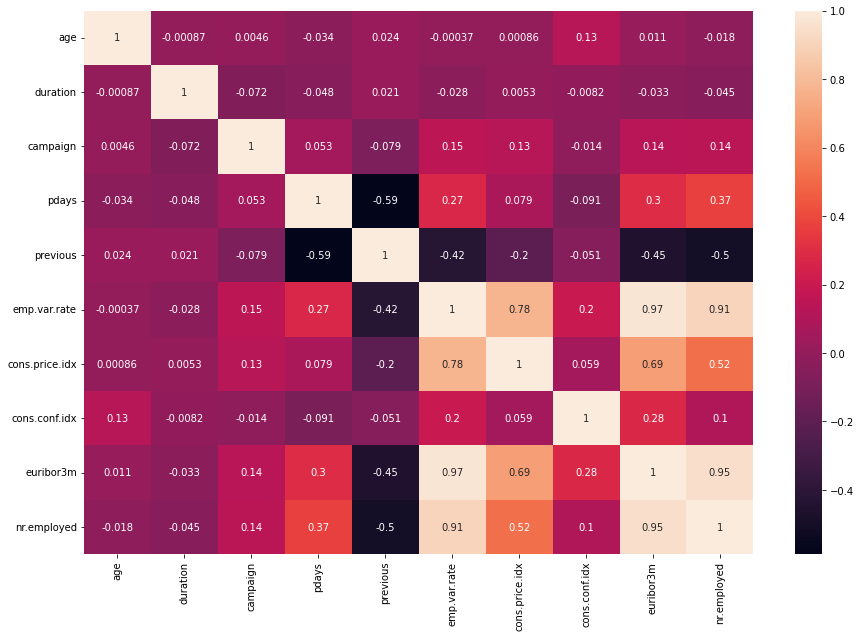

In [87]:
corrMatrix = data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [88]:
y_data = data['y']
X_data = data.drop(['y'],axis = 1)
X_data = pd.get_dummies(X_data)

In [91]:
mm_scale = preprocessing.MinMaxScaler()
X_data[X_data.columns] = mm_scale.fit_transform(X_data[X_data.columns])

In [116]:
def y_val(x):
    if x == 'no':
        return 0
    elif x == 'yes':
        return 1
y_data = y_data.apply(y_val)    

In [118]:
# Split the data for training and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.35,
                                                    random_state = 42)

In [185]:
# PCA
#Train data
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)
# Test Data
pca = PCA(n_components = 0.95)
X_test_reduced = pca.fit_transform(X_test)
X_train_reduced.shape,X_test_reduced.shape

((26772, 29), (14416, 29))

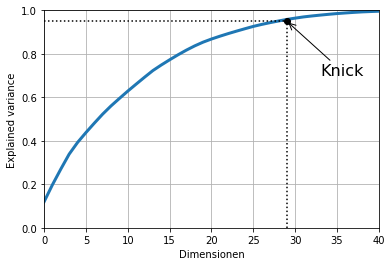

In [186]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 40, 0, 1])
plt.xlabel("Dimensionen")
plt.ylabel("Explained variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Knick", xy=(29, 0.95), xytext=(33, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

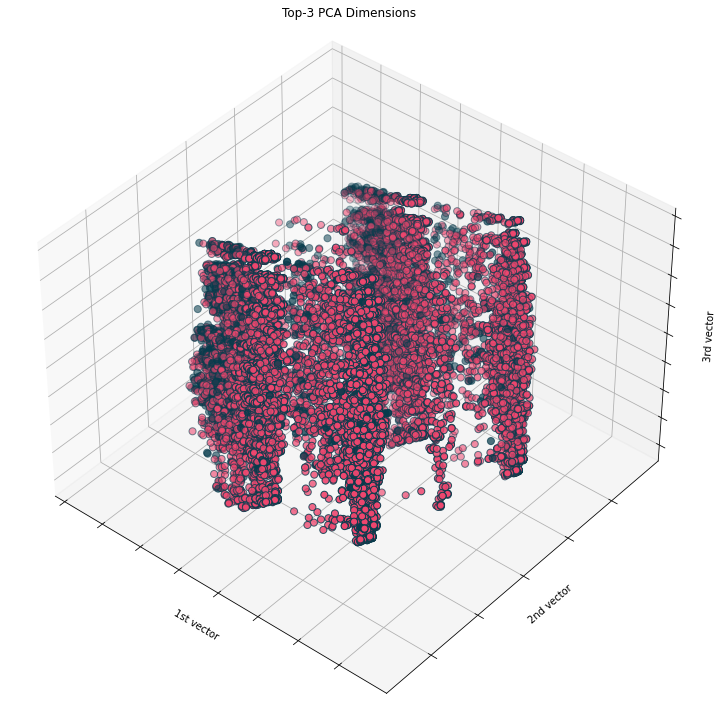

In [142]:
# Plot the result
owncmap = mc.ListedColormap(['#EF476F', '#FFD166', '#06D6A0', '#118AB2', '#F19143', '#073B4C'])
fig = plt.figure(1, figsize = (10, 10))
ax = fig.add_subplot(111, projection="3d", elev=-140, azim=50)
ax.set_position([0, 0, 0.95, 1])

ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2],      # first three dimensions of PCA
           c = y_train,                                               # color-coded by label
           cmap = owncmap, edgecolor = '#073B4C', s = 50)
ax.set_title("Top-3 PCA Dimensions")
ax.set_xlabel("1st vector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd vector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd vector")
ax.w_zaxis.set_ticklabels([])
plt.draw()

In [187]:
print(pca.explained_variance_)                                    # absolute values
print(pca.explained_variance_ratio_)                              # percentage values

[7.33160207e-01 4.81054343e-01 4.42081531e-01 4.21979617e-01
 3.28324605e-01 2.79011803e-01 2.64692590e-01 2.55895529e-01
 2.31154177e-01 2.10587922e-01 2.06620005e-01 1.96948294e-01
 1.94267262e-01 1.88272904e-01 1.56790178e-01 1.46729076e-01
 1.40755019e-01 1.31966469e-01 1.19962672e-01 1.05294349e-01
 8.81857334e-02 7.88695833e-02 7.41208425e-02 6.99816036e-02
 6.74413210e-02 6.55258901e-02 5.57573235e-02 5.02835916e-02
 4.58924206e-02 4.44977907e-02 3.66233425e-02 3.44199874e-02
 2.68798744e-02 2.41799108e-02 2.24681726e-02 2.09423881e-02
 1.72541097e-02 1.58435705e-02 1.40187496e-02 9.80472485e-03
 8.84686252e-03 8.26741954e-03 4.76125337e-03 2.83605998e-03
 2.44169434e-03 2.34672115e-03 1.95978662e-03 7.86255467e-04
 4.78934432e-04 3.40867320e-04 1.67705384e-04 1.11839857e-04
 4.37040429e-31 2.38734639e-31 9.44432254e-32 6.54124689e-32
 4.90807165e-32 4.59252055e-32 4.38215192e-32 3.20151731e-32
 1.50261774e-32 1.06704312e-32 8.92290943e-34]
[1.19565227e-01 7.84513004e-02 7.20955

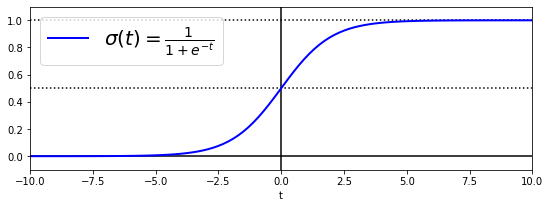

In [148]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

In [188]:
log_reg = LogisticRegression(multi_class = 'ovr',
             class_weight = None, 
             solver= 'saga', 
             max_iter = 10000)

In [189]:
log_reg.fit(X_train_reduced,y_train)

LogisticRegression(max_iter=10000, multi_class='ovr', solver='saga')

In [169]:
y_cla_pred = log_reg.predict(X_test_reduced)

In [190]:
log_reg.score(X_test_reduced, y_test)# The accuracy for the test data set

0.8883185349611543

In [191]:
probs = log_reg.predict_proba(X_test_reduced)
probs = probs[:,1]

In [193]:
y_probas_log_reg = cross_val_predict(log_reg,X_train_reduced, y_train,cv=3, method="predict_proba" )
probs_lr = y_probas_log_reg[:,1]

In [196]:
fpr, tpr, thresholds = roc_curve(y_train, probs_lr)

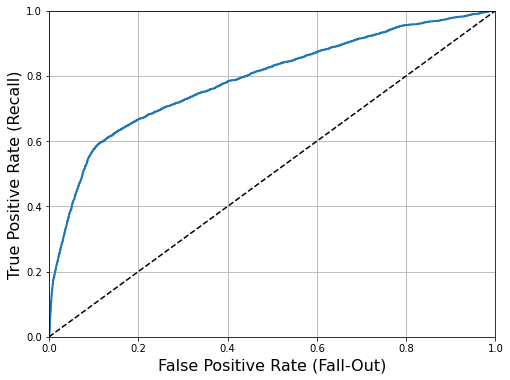

In [197]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

In [199]:
rf_params = {'criterion': 'entropy', 
             'max_depth': 15, 
             'n_estimators': 22984, 
             'min_samples_leaf': 3, 
             'min_samples_split': 9, 
             'max_leaf_nodes': 239, 
             'random_state': 22}

dt_params = {'criterion': 'entropy', 
             'max_depth': 35, 
             'min_samples_leaf': 4, 
             'min_samples_split': 23, 
             'max_leaf_nodes': 169}

svc_params = {'kernel': 'poly',
              'degree': 3,
              'coef0' : 1,
              'C': 5 }

knn_params = {'weights': 'distance', 
              'n_neighbors': 32}

lr_params = {'multi_class':'ovr',
             'class_weight': None, 
             'solver': 'saga', 
             'max_iter':10000}

In [200]:
models =    {'dt':DecisionTreeClassifier(**dt_params),
               'rf':RandomForestClassifier(**rf_params), 
               'svc':SVC(**svc_params), 
               'kn':KNeighborsClassifier(**knn_params),  
               'lr':LogisticRegression(**lr_params)}

model_abrv = {'dt':'Decision Tree Classifier', 
             'rf':'Random Forest Classifier',
              'svc':'Support Vector Machines',
              'kn':'K-Nearest Neighbors', 
              'lr':'Logistic Regression'}

In [201]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
    Saves confusion matrix file to jpg file."""
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
#    if save == True:
#        plt.savefig('tuned_' + model_abrv[model] + '_confusion_matrix.jpg')
    plt.show()

In [202]:
def model(clf, X_train=X_train_reduced, X_test=X_test_reduced, y_train=y_train, y_test=y_test, models=models, save=False, print_stat=True, inc_train=False, cv=False):
    """Trains models and outputs score metrics. Takes an identifier, list of models, and split dataset as inputs and has options for saving model, 
    printing confusion matrix and classification report and getting cross-validated 5 fold accuracy."""
    clf_model = models[clf]
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    if print_stat == True:
        clf_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).T
#        clf_report.to_csv('tuned_' + model_abrv[clf] + '_classification_report.csv')
        print(model_abrv[clf])
        print('\nTest Stats\n', classification_report(y_test,y_pred))
        print_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels(y_test, y_pred), model=clf)
        if inc_train == True:
            print(model_abrv[clf])
            print('\nTrain Stats\n', classification_report(y_train,clf_model.predict(X_train)))
            print_confusion_matrix(confusion_matrix(y_train, clf_model.predict(X_train)), unique_labels(y_test, y_pred), model=clf)
    if cv == True:
        print(model_abrv[clf] + ' CV Accuracy:',  
              np.mean(cross_val_score(clf_model, X_train, y_train, cv=5, scoring='accuracy')))
    if save == True:
        return clf_model

In [ ]:
for key in models.keys():
    model(key, cv=True, print_stat=False)

Decision Tree Classifier CV Accuracy: 0.8892873937023446


In [ ]:
for key in models.keys():
    model(key, inc_train=True)